In [1]:
import pandas as pd
import requests
import networkx as nx
import random
from collections import Counter
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
url = "https://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202023/NBT23FRI_outputs.xlsx"

r = requests.get(url)
with open("NBT23FRI_outputs.xlsx", "wb") as f:
    f.write(r.content)

xls = pd.ExcelFile("NBT23FRI_outputs.xlsx")
print(xls.sheet_names)

['_Cover', 'Link_Loads', 'Link_Frequencies', 'Line_Boarders', 'Station_Flows', 'Station_Entries', 'Station_Exits', 'Station_Boarders', 'Station_Alighters']


In [3]:
df_links = pd.read_excel(xls, sheet_name="Link_Loads", header=2)
df_flows = pd.read_excel(xls, sheet_name="Station_Flows", header=2)
df_entries = pd.read_excel(xls, sheet_name="Station_Entries", header=2)
df_exits = pd.read_excel(xls, sheet_name="Station_Exits", header=2)
df_boarders = pd.read_excel(xls, sheet_name="Station_Boarders", header=2)
df_alighters = pd.read_excel(xls, sheet_name="Station_Alighters", header=2)

# Extract a sorted list of interchange station names from flow data
def extract_interchange_stations(df_flows):
    interchange_rows = df_flows[df_flows["Movement"].str.contains("Interchange", na=False)]
    interchange_stations = sorted(interchange_rows["To Station"].dropna().unique())
    return interchange_stations

# Construct a directed graph where nodes are stations and edges represent flows
def build_graph_from_links(df_links, entry_stations=None, exit_stations=None):
    G = nx.DiGraph()
    for _, r in df_links.iterrows():
        # Add edge with weight = flow volume
        G.add_edge(r["From Station"], r["To Station"], weight=r["Total"])
    # Ensure all entry and exit stations are in the graph
    if len(entry_stations) > 0:
        for station in entry_stations:
            if station not in G:
                G.add_node(station)
    if len(exit_stations) > 0:
        for station in exit_stations:
            if station not in G:
                G.add_node(station)
    return G

In [13]:
import pandas as pd
from itertools import combinations

try:
    from rapidfuzz import process, fuzz
    _HAS_FUZZ = True
except Exception:
    _HAS_FUZZ = False


def normalize_name(s: str) -> str:
    """Lightweight normalizer for station names across datasets."""
    if pd.isna(s):
        return ""
    s = str(s).lower()
    junk = [
        " underground", " underground station", " station", " rail station",
        " (dlr)", " dlr", " lu", " tube", " elizabeth line", " overground"
    ]
    for j in junk:
        s = s.replace(j, "")
    for ch in [",", ".", "(", ")", "-", "–", "—", "/"]:
        s = s.replace(ch, " ")
    s = " ".join(s.split())
    return s


def load_facility_table(path_or_df):
    """
    Load facility table with columns (case-insensitive):
      'Station Name', 'Lift access', 'Main bus interchange'(optional)
    'Lift access' is 1 (yes) or NaN/blank (no).
    Returns DataFrame with:
      Station, has_lift (bool), name_norm
    """
    df = path_or_df if isinstance(path_or_df, pd.DataFrame) else pd.read_excel(path_or_df)

    cols = {c.lower().strip(): c for c in df.columns}
    st_col   = cols.get("station name")
    lift_col = cols.get("lift access")
    if not all([st_col, lift_col]):
        raise ValueError(f"Expect columns: 'Station Name' & 'Lift access'. Got: {list(df.columns)}")

    def one_to_bool(x):
        return True if (pd.notna(x) and (str(x).strip() in {"1", "true", "True"} or x == 1)) else False

    out = pd.DataFrame({
        "Station": df[st_col].astype(str),
        "has_lift": df[lift_col].map(one_to_bool),
    })
    out["name_norm"] = out["Station"].map(normalize_name)
    return out

def match_candidates_to_facility_lift_only(
    candidates,
    facility_df,
    score_cutoff=90,
    keep_condition="no_lift",
    keep_unmatched=False
):
    """
    Filter candidates based on facility table for lift access.
    """
    assert keep_condition in {"no_lift", "has_lift"}
    want = (keep_condition == "has_lift")

    filtered = []
    rows = []
    fac_names = facility_df["name_norm"].tolist()

    for s in candidates:
        s_norm = normalize_name(s)

        if _HAS_FUZZ:
            best = process.extractOne(
                s_norm, fac_names,
                scorer=fuzz.token_sort_ratio,
                score_cutoff=score_cutoff
            )
            if best:
                idx = best[2]
                rec = facility_df.iloc[idx]
                ok = (rec["has_lift"] == want)
                if ok:
                    filtered.append(s)
                rows.append({
                    "candidate": s,
                    "candidate_norm": s_norm,
                    "matched_station": rec["Station"],
                    "score": best[1],
                    "has_lift": rec["has_lift"],
                    "kept": bool(ok)
                })
            else:
                if keep_unmatched:
                    filtered.append(s)
                rows.append({
                    "candidate": s,
                    "candidate_norm": s_norm,
                    "matched_station": None,
                    "score": None,
                    "has_lift": None,
                    "kept": bool(keep_unmatched)
                })
        else:
            hit = facility_df[facility_df["name_norm"] == s_norm]
            if not hit.empty:
                rec = hit.iloc[0]
                ok = (rec["has_lift"] == want)
                if ok:
                    filtered.append(s)
                rows.append({
                    "candidate": s,
                    "candidate_norm": s_norm,
                    "matched_station": rec["Station"],
                    "score": 100,
                    "has_lift": rec["has_lift"],
                    "kept": bool(ok)
                })
            else:
                if keep_unmatched:
                    filtered.append(s)
                rows.append({
                    "candidate": s,
                    "candidate_norm": s_norm,
                    "matched_station": None,
                    "score": None,
                    "has_lift": None,
                    "kept": bool(keep_unmatched)
                })

    report = pd.DataFrame(rows)
    return filtered, report



def suggest_new_bus_stops_from_diff(
    df_od,
    facility_df,
    max_new_stops=3,
    min_diff_threshold=15,
    fuzzy_cutoff=90,
    keep_unmatched=False,
    keep_condition="no_lift",
):
    """
    Suggest new bus stops based on OD pairs with high total diff time.
    Expects df_od to contain: ['Start_Station', 'End_Station', 'Count', 'Total']
    facility_df: output of load_facility_table(...)
    with 'has_lift' column.
    Only keep candidates that (by fuzzy match) have NO lift access.
    """
    # Step 1: Filter OD pairs with long total diff time
    df_long_travel = df_od[df_od["time_diff"] >= min_diff_threshold].copy()
    if df_long_travel.empty:
        print("No OD pairs exceed the minimum time_diff threshold.")
        return tuple(), None

    # Step 2: Identify candidate stations from underserved OD pairs
    candidate_nodes = sorted(set(df_long_travel["Start_Station"]).union(df_long_travel["End_Station"]))
    print(f"Found {len(df_long_travel)} OD pairs with time_diff ≥ {min_diff_threshold}")
    print(f"Raw candidate stations: {len(candidate_nodes)}")

    # Step 2.5: Apply lift-only facility filter via fuzzy matching
    filtered_candidates, match_report = match_candidates_to_facility_lift_only(
        candidate_nodes,
        facility_df,
        score_cutoff=fuzzy_cutoff,
        keep_condition=keep_condition,
        keep_unmatched=keep_unmatched
    )
    print(f"Candidates after lift-only filter ({keep_condition}): {len(filtered_candidates)}")

    if not filtered_candidates:
        print("No candidates remain after lift-only filter.")
        return tuple(), match_report

    # Step 3: Try all combinations of new stop placements (brute-force for small-scale test)
    k = min(max_new_stops, len(filtered_candidates))
    candidate_nodes = list(filtered_candidates)

    best_total_cost = float("inf")
    best_combo = None


    for combo in combinations(candidate_nodes, max_new_stops):
        total_cost = 0
        for _, row in df_long_travel.iterrows():
            u, v = row["Start_Station"], row["End_Station"]
            count = row["Frequency"]
            time_diff = row["time_diff"]

            if u in combo or v in combo:
                total_cost += 1 * count
            else:
                total_cost += time_diff * count

        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_combo = combo

    print(f"Suggested new bus stop locations (up to {max_new_stops}): {best_combo}")
    print(f"Total weighted accessibility gap reduced to: {best_total_cost:.2f}")

    return best_combo, match_report

# Count coverage rate

In [32]:
def coverage_rates(df_od, best_stops, threshold, diff_col="time_diff"):
    df = df_od.copy()
    df[diff_col] = pd.to_numeric(df[diff_col], errors="coerce").fillna(0)
    wcol = "Count" if "Count" in df.columns else ("Frequency" if "Frequency" in df.columns else None)
    if wcol is None:
        df["__w__"] = 1; wcol = "__w__"
    df = df[df[diff_col] >= threshold].copy()
    if df.empty:
        return {"num_od":0, "covered_pairs":0, "pair_cov":0.0, "trip_cov":0.0}
    s = set(best_stops)
    covered = df["Start_Station"].isin(s) | df["End_Station"].isin(s)
    pair_cov = float(covered.mean())
    trip_cov = float(df.loc[covered, wcol].sum() / df[wcol].sum()) if df[wcol].sum() > 0 else 0.0
    return {"num_od": int(len(df)), "covered_pairs": int(covered.sum()),
            "pair_cov": pair_cov, "trip_cov": trip_cov}


# max_new_stops=2

In [53]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od,
    facility_df=fac,
    max_new_stops=2,
    min_diff_threshold=31.9,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 46 OD pairs with time_diff ≥ 31.9
Raw candidate stations: 62
Candidates after lift-only filter (no_lift): 46
Suggested new bus stop locations (up to 2): ('High Barnet', 'West Ruislip')
Total weighted accessibility gap reduced to: 46317.28


In [54]:
m = coverage_rates(df_od, best_stops, threshold=31.9, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 15/46,  pair_cov=32.6%,  trip_cov=30.9%


In [57]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od,
    facility_df=fac,
    max_new_stops=2,
    min_diff_threshold=34.1,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 40 OD pairs with time_diff ≥ 34.1
Raw candidate stations: 54
Candidates after lift-only filter (no_lift): 41
Suggested new bus stop locations (up to 2): ('High Barnet', 'West Ruislip')
Total weighted accessibility gap reduced to: 41107.90


In [58]:
m = coverage_rates(df_od, best_stops, threshold=34.1, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 15/40,  pair_cov=37.5%,  trip_cov=35.2%


# max_new_stops=3

In [47]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od,
    facility_df=fac,
    max_new_stops=3,
    min_diff_threshold=31.9,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 46 OD pairs with time_diff ≥ 31.9
Raw candidate stations: 62
Candidates after lift-only filter (no_lift): 46
Suggested new bus stop locations (up to 3): ('High Barnet', 'Turnpike Lane', 'West Ruislip')
Total weighted accessibility gap reduced to: 41329.28


In [48]:
m = coverage_rates(df_od, best_stops, threshold=31.9, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 16/46,  pair_cov=34.8%,  trip_cov=34.2%


In [49]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od,
    facility_df=fac,
    max_new_stops=3,
    min_diff_threshold=34.1,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 40 OD pairs with time_diff ≥ 34.1
Raw candidate stations: 54
Candidates after lift-only filter (no_lift): 41
Suggested new bus stop locations (up to 3): ('High Barnet', 'Turnpike Lane', 'West Ruislip')
Total weighted accessibility gap reduced to: 36119.90


In [50]:
m = coverage_rates(df_od, best_stops, threshold=34.1, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 16/40,  pair_cov=40.0%,  trip_cov=39.1%


In [21]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od,
    facility_df=fac,
    max_new_stops=3,
    min_diff_threshold=25.3,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 61 OD pairs with time_diff ≥ 25.3
Raw candidate stations: 78
Candidates after lift-only filter (no_lift): 59
Suggested new bus stop locations (up to 3): ('Hammersmith (H&C)', 'High Barnet', 'West Ruislip')
Total weighted accessibility gap reduced to: 52045.95


In [22]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od,
    facility_df=fac,
    max_new_stops=3,
    min_diff_threshold=14.7,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 92 OD pairs with time_diff ≥ 14.7
Raw candidate stations: 113
Candidates after lift-only filter (no_lift): 82
Suggested new bus stop locations (up to 3): ('Hammersmith (H&C)', 'High Barnet', 'West Ruislip')
Total weighted accessibility gap reduced to: 65358.30


# max_new_stops=4

In [66]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od,
    facility_df=fac,
    max_new_stops=4,
    min_diff_threshold=31.9,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 46 OD pairs with time_diff ≥ 31.9
Raw candidate stations: 62
Candidates after lift-only filter (no_lift): 46
Suggested new bus stop locations (up to 4): ('Hammersmith (H&C)', 'High Barnet', 'Turnpike Lane', 'West Ruislip')
Total weighted accessibility gap reduced to: 36732.70


In [67]:
m = coverage_rates(df_od, best_stops, threshold=31.9, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 19/46,  pair_cov=41.3%,  trip_cov=41.5%


In [59]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od,
    facility_df=fac,
    max_new_stops=4,
    min_diff_threshold=34.1,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 40 OD pairs with time_diff ≥ 34.1
Raw candidate stations: 54
Candidates after lift-only filter (no_lift): 41
Suggested new bus stop locations (up to 4): ('Hammersmith (H&C)', 'High Barnet', 'Turnpike Lane', 'West Ruislip')
Total weighted accessibility gap reduced to: 32469.32


In [60]:
m = coverage_rates(df_od, best_stops, threshold=34.1, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 18/40,  pair_cov=45.0%,  trip_cov=44.7%


In [24]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od,
    facility_df=fac,
    max_new_stops=4,
    min_diff_threshold=25.3,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 61 OD pairs with time_diff ≥ 25.3
Raw candidate stations: 78
Candidates after lift-only filter (no_lift): 59
Suggested new bus stop locations (up to 4): ('Hammersmith (H&C)', 'High Barnet', 'Turnpike Lane', 'West Ruislip')
Total weighted accessibility gap reduced to: 47057.95


# 95% quantile threshold for time_diff

## max_new_stops=2

In [63]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)

# 95% quantile threshold for time_diff
threshold = df_od["time_diff"].quantile(0.95)
df_od_trimmed = df_od[df_od["time_diff"] <= threshold]

best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od_trimmed,
    facility_df=fac,
    max_new_stops=2,
    min_diff_threshold=31.9,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 36 OD pairs with time_diff ≥ 31.9
Raw candidate stations: 49
Candidates after lift-only filter (no_lift): 35
Suggested new bus stop locations (up to 2): ('High Barnet', 'West Ruislip')
Total weighted accessibility gap reduced to: 29762.13


In [64]:
m = coverage_rates(df_od_trimmed, best_stops, threshold=31.9, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 11/36,  pair_cov=30.6%,  trip_cov=30.4%


In [62]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)

# 95% quantile threshold for time_diff
threshold = df_od["time_diff"].quantile(0.95)
df_od_trimmed = df_od[df_od["time_diff"] <= threshold]

best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od_trimmed,
    facility_df=fac,
    max_new_stops=2,
    min_diff_threshold=34.1,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 30 OD pairs with time_diff ≥ 34.1
Raw candidate stations: 41
Candidates after lift-only filter (no_lift): 30
Suggested new bus stop locations (up to 2): ('High Barnet', 'West Ruislip')
Total weighted accessibility gap reduced to: 24552.75


In [65]:
m = coverage_rates(df_od_trimmed, best_stops, threshold=34.1, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 11/30,  pair_cov=36.7%,  trip_cov=36.1%


## max_new_stops=3

In [44]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)

# 95% quantile threshold for time_diff
threshold = df_od["time_diff"].quantile(0.95)
df_od_trimmed = df_od[df_od["time_diff"] <= threshold]

best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od_trimmed,
    facility_df=fac,
    max_new_stops=3,
    min_diff_threshold=31.9,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 36 OD pairs with time_diff ≥ 31.9
Raw candidate stations: 49
Candidates after lift-only filter (no_lift): 35
Suggested new bus stop locations (up to 3): ('High Barnet', 'Uxbridge', 'West Ruislip')
Total weighted accessibility gap reduced to: 26464.13


In [46]:
m = coverage_rates(df_od_trimmed, best_stops, threshold=31.9, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 13/36,  pair_cov=36.1%,  trip_cov=37.5%


In [42]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)

# 95% quantile threshold for time_diff
threshold = df_od["time_diff"].quantile(0.95)
df_od_trimmed = df_od[df_od["time_diff"] <= threshold]

best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od_trimmed,
    facility_df=fac,
    max_new_stops=3,
    min_diff_threshold=34.1,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 30 OD pairs with time_diff ≥ 34.1
Raw candidate stations: 41
Candidates after lift-only filter (no_lift): 30
Suggested new bus stop locations (up to 3): ('High Barnet', 'Uxbridge', 'West Ruislip')
Total weighted accessibility gap reduced to: 21254.75


In [43]:
m = coverage_rates(df_od_trimmed, best_stops, threshold=34.1, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 13/30,  pair_cov=43.3%,  trip_cov=44.5%


## max_new_stops=4

In [40]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)

# 95% quantile threshold for time_diff
threshold = df_od["time_diff"].quantile(0.95)
df_od_trimmed = df_od[df_od["time_diff"] <= threshold]

best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od_trimmed,
    facility_df=fac,
    max_new_stops=4,
    min_diff_threshold=34.1,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 30 OD pairs with time_diff ≥ 34.1
Raw candidate stations: 41
Candidates after lift-only filter (no_lift): 30
Suggested new bus stop locations (up to 4): ('Belsize Park', 'High Barnet', 'Uxbridge', 'West Ruislip')
Total weighted accessibility gap reduced to: 19434.35


In [41]:
m = coverage_rates(df_od_trimmed, best_stops, threshold=34.1, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 14/30,  pair_cov=46.7%,  trip_cov=48.8%


In [30]:
df_od = pd.read_csv("OD_Routes_diff_ratio.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)

# 95% quantile threshold for time_diff
threshold = df_od["time_diff"].quantile(0.95)
df_od_trimmed = df_od[df_od["time_diff"] <= threshold]

best_stops, match_report = suggest_new_bus_stops_from_diff(
    df_od_trimmed,
    facility_df=fac,
    max_new_stops=4,
    min_diff_threshold=31.9,
    fuzzy_cutoff=85,
    keep_unmatched=True,
    keep_condition="no_lift"
)

Found 36 OD pairs with time_diff ≥ 31.9
Raw candidate stations: 49
Candidates after lift-only filter (no_lift): 35
Suggested new bus stop locations (up to 4): ('Hammersmith (H&C)', 'High Barnet', 'Uxbridge', 'West Ruislip')
Total weighted accessibility gap reduced to: 24391.03


In [39]:
m = coverage_rates(df_od_trimmed, best_stops, threshold=31.9, diff_col="time_diff")
print(f"covered_pairs: {m['covered_pairs']}/{m['num_od']},  pair_cov={m['pair_cov']:.1%},  trip_cov={m['trip_cov']:.1%}")


covered_pairs: 15/36,  pair_cov=41.7%,  trip_cov=43.9%


# Cumulative Distribution of Step-free Travel Time Differences

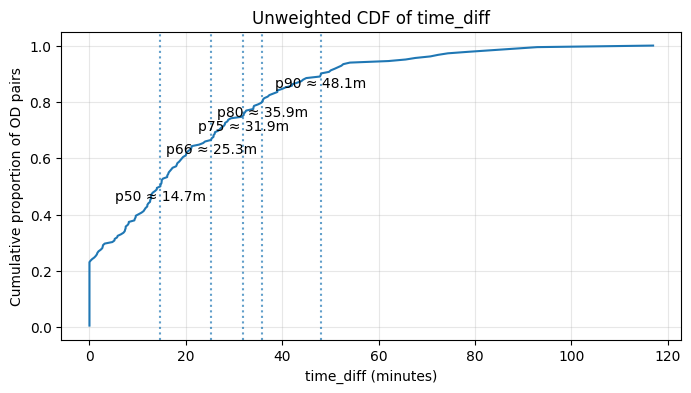

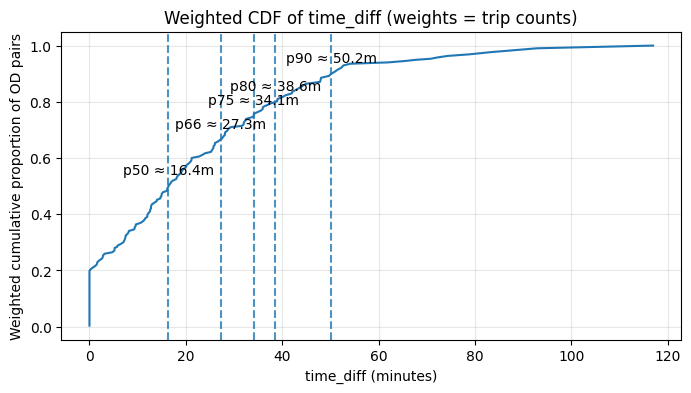

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- load & clean ---
df = pd.read_csv("OD_Routes_diff_ratio.csv")
df["time_diff"] = pd.to_numeric(df["time_diff"], errors="coerce").fillna(0).clip(lower=0)

# auto-detect weight column (trip counts)
if "Count" in df.columns:
    wcol = "Count"
elif "Frequency" in df.columns:
    wcol = "Frequency"
else:
    wcol = "__w__"; df[wcol] = 1

# helper: weighted quantile
def weighted_quantile(values, quantiles, weights):
    values = np.asarray(values); weights = np.asarray(weights)
    qs = np.atleast_1d(quantiles)
    idx = np.argsort(values)
    x, w = values[idx], weights[idx]
    c = np.cumsum(w) / w.sum()
    return np.interp(qs, c, x)

vals = df["time_diff"].to_numpy()
ws   = df[wcol].to_numpy()
qs   = [0.50, 2/3, 0.75, 0.80, 0.90]

# -----------------------
# Figure 1: Unweighted CDF
# -----------------------
x_unw = np.sort(vals)
cdf_unw = np.arange(1, len(x_unw)+1) / len(x_unw)
uq = np.quantile(vals, qs)

plt.figure(figsize=(8,4))
plt.plot(x_unw, cdf_unw, linestyle='-')
for q, v in zip(qs, uq):
    plt.axvline(v, linestyle=':', alpha=0.7)
    y = max(q - 0.06, 0.02)  # put label slightly below the quantile line
    plt.text(v, y, f"p{int(q*100)} ≈ {v:.1f}m", ha='center', va='bottom', rotation=0)
plt.xlabel("time_diff (minutes)")
plt.ylabel("Cumulative proportion of OD pairs")
plt.title("Unweighted CDF of time_diff")
plt.grid(alpha=0.3)
plt.show()

# -----------------------
# Figure 2: Weighted CDF
# -----------------------
idx = np.argsort(vals)
x = vals[idx]; w = ws[idx]
wcdf = np.cumsum(w) / w.sum()
wq = weighted_quantile(vals, qs, ws)

plt.figure(figsize=(8,4))
plt.plot(x, wcdf, linestyle='-')
for q, v in zip(qs, wq):
    plt.axvline(v, linestyle='--', alpha=0.8)
    y = min(q + 0.03, 0.98)  # put label slightly above the quantile line
    plt.text(v, y, f"p{int(q*100)} ≈ {v:.1f}m", ha='center', va='bottom', rotation=0)
plt.xlabel("time_diff (minutes)")
plt.ylabel("Weighted cumulative proportion of OD pairs")
plt.title("Weighted CDF of time_diff (weights = trip counts)")
plt.grid(alpha=0.3)
plt.show()
